# 1 . Import package


In [1]:
from tkinter import Pack
import prerun
import importlib
importlib.reload(prerun)
import cv2
import numpy as np
import random
import time
import glob
import os
import matplotlib.image as mpimg
from skimage import morphology
import matplotlib.pyplot as plt
import Calibration; importlib.reload(Calibration)
from tqdm import tqdm
%matplotlib widget

# 2. Calibration

## 2.1 Calibration parameter

In [2]:
OpticInfo = prerun.prerun(); # * Optic Information

Calibrate {'target_path': '/home/liu/Desktop/Ray_intersection_Opitmize_Parallel/ZoomLens_simulation/target', 'Browse': '', 'calibration_path': '/home/liu/Desktop/Ray_intersection_Opitmize_Parallel/ZoomLens_simulation/calibration', 'Browse0': '', 'output_path': '/home/liu/Desktop/Ray_intersection_Opitmize_Parallel/ZoomLens_simulation/result', 'Browse1': '', 'sensor_type': 'rect', 'pixel_mm': '0.01', 'MLA_F_mm': '2.5', 'MLA_size_mm': '0.25', 'sensorH_resolution': '1600.0', 'magnification': '2.5', 'num_Micro_X': '130.0', 'num_Micro_Y': '80.0', 'dmin_mm': '-50.0', 'dmax_mm': '50.0', 'dnum': '1000.0', 'xmin_mm': '-2.0', 'xmax_mm': '27.6', 'ymin_mm': '-2.0', 'ymax_mm': '18.0', 'scaleFactor': '1.0', 'minIntensity': '100.0', 'maxRayCount': '100.0'}


## 2.2 center detection

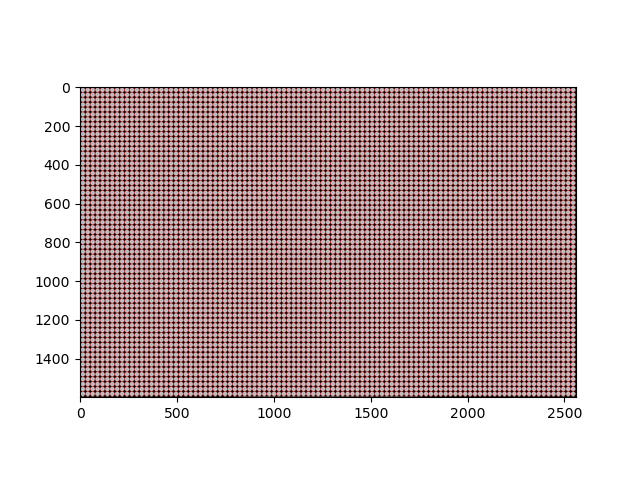

In [3]:
# Real experiment code 
# detected_Image, keypoints = Calibration.center_detect(OpticInfo['calibration_path']) 

# Simulation code
calibration_path = OpticInfo['calibration_path']
calibrationImagePath = os.path.join(calibration_path, 'calibration.tif')
calibrationImage = cv2.imread(calibrationImagePath, cv2.IMREAD_GRAYSCALE)
img = 255 - calibrationImage
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 0
params.maxThreshold = 200
params.filterByArea = True
radius = round(25/2)
params.minArea = 400
params.filterByCircularity = True
params.minCircularity = 0.7
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(img)
output_image = cv2.cvtColor(calibrationImage,cv2.COLOR_GRAY2RGB)
for point in keypoints:
    x = int(point.pt[0])
    y = int(point.pt[1])
    cv2.circle(output_image, (x,y), 0, (0, 0, 255), 2)
output_image = cv2.drawKeypoints(output_image, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
Show_RawCloudPoints = False
Video_RawCloudPoints = False
Show_BallCloudPoints = False
Video_BallCloudPoints = False
Show_DBSCANCloudPoints = False
Video_DBSCANCloudPoints = False
plt.figure()
plt.imshow(output_image)

## 2.3 Verify the calibration

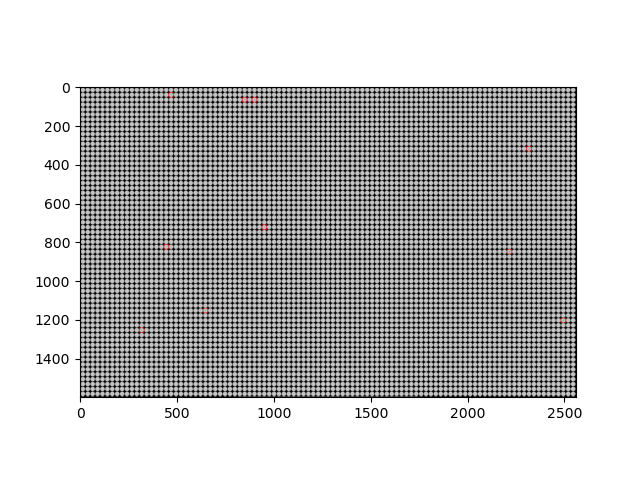

In [4]:
centers = []
for point in keypoints:
    x = point.pt[0]
    y = point.pt[1]
    centers.append([x,y])
centers = np.array(centers)
rounded_centers = np.round(centers).astype(int)
diameter = OpticInfo['MLA_size_mm'] / OpticInfo['pixel_mm']
assert diameter % 2 == 1
radius = (diameter - 1)/2
x = np.linspace(-1 * radius,radius,num = int(diameter)).astype(int)
y = x
x, y = np.meshgrid(x,y)
x = x.flatten()
y = y.flatten()
Rays = []
for i, center in enumerate(centers):
    center_x = rounded_centers[i, 0]
    center_y = rounded_centers[i, 1]
    center_actual_x = center[0]
    center_actual_y = center[1]
    pixel_x_lists = center_x + x
    pixel_y_lists = center_y + y    
    for pixel_x,pixel_y in zip(pixel_x_lists, pixel_y_lists):
        Rays.append([pixel_x, pixel_y, center_actual_x, center_actual_y])
Rays = np.array(Rays)
# ? randomly check several points if it is correct 
calibrationImagePath = os.path.join(OpticInfo['calibration_path'], 'calibration.tif')
calibrationImage = cv2.imread(calibrationImagePath, cv2.IMREAD_GRAYSCALE)
calibrationImage = cv2.cvtColor(calibrationImage,cv2.COLOR_GRAY2RGB)
Num_pixels = diameter**2
Selected_centers_index = random.sample(range(0, len(centers)), 10) # * select 10 random points to confirm center and affiliated points region
for i in Selected_centers_index:
    start_index = int(i * Num_pixels)
    end_index = int((i + 1) * Num_pixels)
    x_min = int(np.min(Rays[start_index:end_index,0]))
    x_max = int(np.max(Rays[start_index:end_index,0]))
    y_min = int(np.min(Rays[start_index:end_index,1]))
    y_max = int(np.max(Rays[start_index:end_index,1]))
    x_center = rounded_centers[i,0]
    y_center = rounded_centers[i,1]
    cv2.rectangle(calibrationImage, (x_min, y_min), (x_max, y_max), (255,0,0), 2)
    cv2.circle(calibrationImage, (x_center, y_center), 0, (0,0,255), 2)
plt.figure()
plt.imshow(calibrationImage)

## 2.4 Close all figure cache

In [6]:
plt.close('all') 

# 3. Reconstruction 3d particle

## 3.1 Prepare place holder for reconstruction in memoroy

In [5]:
from numba import jit
from numba import cuda, types
import math
threshold = OpticInfo['minIntensity']
ImagePath = OpticInfo['target_path']
ImageLists = glob.glob(os.path.join(ImagePath,"*.tif"))
ImageLists.sort()
Xmax = OpticInfo['xmax_mm'] # mm
Xmin = OpticInfo['xmin_mm'] # mm
Ymin = OpticInfo['ymin_mm'] # mm
Ymax = OpticInfo['ymax_mm'] # mm
Zmin = OpticInfo['dmin_mm'] # mm
Zmax = OpticInfo['dmax_mm'] # mm
MLA_diameter = OpticInfo['MLA_size_mm'] # mm
Pixel_size = OpticInfo['pixel_mm'] # mm
MLA_FLength = OpticInfo['MLA_F_mm'] # mm
deltaX = MLA_diameter # select dx
deltaY = MLA_diameter # select dy
NumX = int((Xmax - Xmin) / deltaX)
NumY = int((Ymax - Ymin) / deltaY)
NumZ = int(OpticInfo['dnum']  + 1)
Z_level = np.linspace(Zmin, Zmax, NumZ)
deltaZ = Z_level[1] - Z_level[0]


# * grid and block dimension definition
Rays_Num = len(Rays) # TODO: increase number of threads to to match RayCounts size
RayCounts_Num = NumX * NumY * NumZ # 
DimBlock = 1024
DimGrid = math.ceil(Rays_Num/DimBlock) # * Old one use number of rays instead of voxels
#DimGrid = math.ceil(RayCounts_Num/DimBlock) # * Use voxel numbers
# * image loading
X_1D = np.linspace(Xmin + deltaX / 2, Xmax- deltaX/2, NumX)
Y_1D = np.linspace(Ymin + deltaY / 2, Ymax- deltaY/2, NumY)
Z_1D = Z_level
NumImagePerLoop = 3 # define number of images per stack run
X_2D, Y_2D = np.meshgrid(X_1D, Y_1D)
X_3D, Y_3D, Z_3D = np.meshgrid(X_1D, Y_1D, Z_1D, indexing = 'xy')
X_3D = (np.transpose(X_3D, (2,0,1))).flatten()
Y_3D = (np.transpose(Y_3D, (2,0,1))).flatten()
Z_3D = (np.transpose(Z_3D, (2,0,1))).flatten()
#TODO: using stream cuda will accelerate the data loading and computing 

## 3.2 reconstruction for simulation

In [6]:
@cuda.jit # (device = True)
def UpdateRays_CUDA(device_img, 
                    device_Rays, 
                    device_RayCounts, 
                    Z_level, 
                    threshold, 
                    MLA_FLength, 
                    Pixel_size, 
                    Xmin, 
                    Ymin, 
                    deltaX, 
                    deltaY,
                    NumX,
                    NumY,
                    NumZ):
    # ! create constant memory arrays
    Constant_memory_Z_level = cuda.const.array_like(Z_level)
    gid = cuda.grid(1)
    if gid < Constant_memory_Z_level.shape[0]:
        Z_level[gid] = Constant_memory_Z_level[gid]
    cuda.syncthreads()
    # ! start processing image stacks 

    if gid < device_Rays.shape[0]:
        x = int(device_Rays[gid, 0])
        y = int(device_Rays[gid, 1])
        if device_img[y, x] > threshold:
            for Zindex, Z in enumerate(Constant_memory_Z_level):
                scale = Z / MLA_FLength
                newX = (device_Rays[gid,0] - device_Rays[gid,2] ) * Pixel_size * scale + device_Rays[gid, 2] * Pixel_size
                newY = (device_Rays[gid,1] - device_Rays[gid,3] ) * Pixel_size * scale + device_Rays[gid, 3] * Pixel_size
                Xindex = round((newX - Xmin) / deltaX)
                Yindex = round((newY - Ymin) / deltaY)
                index_Ray = Zindex*(NumX * NumY) + Yindex * NumX + Xindex #? Maybe there is problem about indexing
                cuda.atomic.add(device_RayCounts, index_Ray, 1) 
frameID = 0 # change the frame ID to test others
img = mpimg.imread(ImageLists[frameID])
print('there are {} rays in frame {}'.format(np.sum(img > 100), frameID))
device_img = cuda.to_device(img)
device_Rays = cuda.to_device(Rays)
device_Z_level = cuda.to_device(Z_level)
RayCounts_CPU = np.zeros(NumX * NumY * NumZ, dtype = np.uint32)
device_RayCounts = cuda.to_device(RayCounts_CPU)
UpdateRays_CUDA[DimGrid, DimBlock](device_img, 
                                       device_Rays, 
                                       device_RayCounts, 
                                       device_Z_level, 
                                       threshold, 
                                       MLA_FLength, 
                                       Pixel_size, 
                                       Xmin, 
                                       Ymin, 
                                       deltaX, 
                                       deltaY,
                                       NumX,
                                       NumY,
                                       NumZ)
cuda.synchronize()
RayCounts = device_RayCounts.copy_to_host()


there are 5837 rays in frame 0


In [8]:
    #local maximum value search
    img = mpimg.imread(ImageLists[0])
    img_stacks = np.empty([img.shape[0], img.shape[1], end_index - start_index], dtype = img.dtype)
    for i in range(start_index, end_index):
        img_stacks[:,:,i - start_index] = mpimg.imread(ImageLists[i])
    Num_img_per_loop = end_index - start_index
    device_img = cuda.to_device(img_stacks)
    device_Rays = cuda.to_device(Rays)
    device_Z_level = cuda.to_device(Z_level)
    #RayCounts_CPU = np.zeros((NumX,NumY,NumZ, end_index - start_index), dtype = np.uint32)
    #? Try to unroll the RayCounts
    RayCounts_CPU = np.zeros(NumX * NumY * NumZ * (end_index - start_index), dtype = np.uint32)
    device_RayCounts = cuda.to_device(RayCounts_CPU)
    #LocalMax_Indicator_CPU = np.zeros((NumX,NumY,NumZ, end_index - start_index), bool)
    #device_LocalMax_Indicator = cuda.to_device(LocalMax_Indicator_CPU)
    search_rangeX = 4 # ! define search range for x, y 
    search_rangeZ = 10 # ! define search range for z
    minRayCounts = 50 # ! define minimum number of rays for each voxels
    UpdateRays_CUDA[DimGrid, DimBlock](device_img, 
                                       device_Rays, 
                                       device_RayCounts, 
                                       device_Z_level, 
                                       threshold, 
                                       MLA_FLength, 
                                       Pixel_size, 
                                       Xmin, 
                                       Ymin, 
                                       deltaX, 
                                       deltaY,
                                       NumX,
                                       NumY,
                                       NumZ,
                                       Num_img_per_loop)
    cuda.synchronize() # ? maybe not necessary here
    RayCounts = device_RayCounts.copy_to_host()
    #RayCounts_LocalMax_Indicator = device_LocalMax_Indicator.copy_to_host()
    device = cuda.select_device(0)
    device.reset()
    return RayCounts
start_time = time.time()
NumImagePerLoop = 1
NumImages = len(ImageLists)
Numloops = math.ceil(NumImages // NumImagePerLoop)
start_index = 0
end_index = start_index + NumImagePerLoop
cloudpoints = []
minRayCount = 100
for i in tqdm(range(Numloops)):
    if i == Numloops - 1:
        end_index = NumImages
    RayCounts = process_image_stacks(ImageLists,start_index, end_index)
    for j in range(NumImagePerLoop):
        RayCounts_singleFrame = RayCounts[j * (NumX * NumY * NumZ): (j+1)*(NumX*NumY *NumZ)]
        RayCounts_validSingleFrame = RayCounts_singleFrame[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        X_valid = X_3D[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        Y_valid = Y_3D[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        Z_valid = Z_3D[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        cloudpoints.append(np.concatenate((X_valid, Y_valid, Z_valid,RayCounts_validSingleFrame), axis = 1))
        
    start_index += NumImagePerLoop
    end_index += NumImagePerLoop
    
end_time = time.time()
print('the runing time for  cuda optimization for each frame is {} ms'.format((end_time-start_time) * 1000 / NumImages))

100%|███████████████████████████████| 3/3 [00:00<00:00,  4.50it/s]

the runing time for  cuda optimization for each frame is 222.67707188924155 ms


## 3.3 Reconstruction for experiment

In [7]:
from tqdm import tqdm
def process_image_stacks(ImageLists, start_index, end_index):
    @cuda.jit # (device = True)
    def UpdateRays_CUDA(device_img, 
                        device_Rays, 
                        device_RayCounts, 
                        Z_level, 
                        threshold, 
                        MLA_FLength, 
                        Pixel_size, 
                        Xmin, 
                        Ymin, 
                        deltaX, 
                        deltaY,
                        NumX,
                        NumY,
                        NumZ,
                        Num_images):
        # ! create constant memory arrays
        Constant_memory_Z_level = cuda.const.array_like(Z_level)
        gid = cuda.grid(1)
        if gid < Constant_memory_Z_level.shape[0]:
            Z_level[gid] = Constant_memory_Z_level[gid]
        cuda.syncthreads()
        # ! start processing image stacks 
        
        if gid < device_Rays.shape[0]:
            x = int(device_Rays[gid, 0])
            y = int(device_Rays[gid, 1])
            for i in range(Num_images):
                if device_img[y, x, i] > threshold:
                    for Zindex, Z in enumerate(Constant_memory_Z_level):
                        scale = Z / MLA_FLength
                        newX = (device_Rays[gid,0] - device_Rays[gid,2] ) * Pixel_size * scale + device_Rays[gid, 2] * Pixel_size
                        newY = (device_Rays[gid,1] - device_Rays[gid,3] ) * Pixel_size * scale + device_Rays[gid, 3] * Pixel_size
                        Xindex = round((newX - Xmin) / deltaX)
                        Yindex = round((newY - Ymin) / deltaY)
                        index_Ray = i * (NumX*NumY*NumZ) + Zindex*(NumX * NumY) + Yindex * NumX + Xindex #? Maybe there is problem about indexing
                        cuda.atomic.add(device_RayCounts, index_Ray, 1)  

    #local maximum value search
    img = mpimg.imread(ImageLists[0])
    img_stacks = np.empty([img.shape[0], img.shape[1], end_index - start_index], dtype = img.dtype)
    for i in range(start_index, end_index):
        img_stacks[:,:,i - start_index] = mpimg.imread(ImageLists[i])
    Num_img_per_loop = end_index - start_index
    device_img = cuda.to_device(img_stacks)
    device_Rays = cuda.to_device(Rays)
    device_Z_level = cuda.to_device(Z_level)
    #RayCounts_CPU = np.zeros((NumX,NumY,NumZ, end_index - start_index), dtype = np.uint32)
    #? Try to unroll the RayCounts
    RayCounts_CPU = np.zeros(NumX * NumY * NumZ * (end_index - start_index), dtype = np.uint32)
    device_RayCounts = cuda.to_device(RayCounts_CPU)
    #LocalMax_Indicator_CPU = np.zeros((NumX,NumY,NumZ, end_index - start_index), bool)
    #device_LocalMax_Indicator = cuda.to_device(LocalMax_Indicator_CPU)
    search_rangeX = 4 # ! define search range for x, y 
    search_rangeZ = 10 # ! define search range for z
    minRayCounts = 50 # ! define minimum number of rays for each voxels
    UpdateRays_CUDA[DimGrid, DimBlock](device_img, 
                                       device_Rays, 
                                       device_RayCounts, 
                                       device_Z_level, 
                                       threshold, 
                                       MLA_FLength, 
                                       Pixel_size, 
                                       Xmin, 
                                       Ymin, 
                                       deltaX, 
                                       deltaY,
                                       NumX,
                                       NumY,
                                       NumZ,
                                       Num_img_per_loop)
    cuda.synchronize() # ? maybe not necessary here
    RayCounts = device_RayCounts.copy_to_host()
    #RayCounts_LocalMax_Indicator = device_LocalMax_Indicator.copy_to_host()
    device = cuda.select_device(0)
    device.reset()
    return RayCounts
start_time = time.time()
NumImagePerLoop = 3 # Change this number for fast processing
NumImages = len(ImageLists)
Numloops = math.ceil(NumImages // NumImagePerLoop)
start_index = 0
end_index = start_index + NumImagePerLoop
cloudpoints = []
minRayCount = 100
for i in tqdm(range(Numloops)):
    if i == Numloops - 1:
        end_index = NumImages
    RayCounts = process_image_stacks(ImageLists,start_index, end_index)
    for j in range(NumImagePerLoop):
        RayCounts_singleFrame = RayCounts[j * (NumX * NumY * NumZ): (j+1)*(NumX*NumY *NumZ)]
        RayCounts_validSingleFrame = RayCounts_singleFrame[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        X_valid = X_3D[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        Y_valid = Y_3D[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        Z_valid = Z_3D[RayCounts_singleFrame > minRayCount].reshape(-1,1)
        cloudpoints.append(np.concatenate((X_valid, Y_valid, Z_valid,RayCounts_validSingleFrame), axis = 1))
        
    start_index += NumImagePerLoop
    end_index += NumImagePerLoop
    
end_time = time.time()
print('the runing time for  cuda optimization for each frame is {} ms'.format((end_time-start_time) * 1000 / NumImages))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]

the runing time for  cuda optimization for each frame is 106.44674301147461 ms


## 3.* Load simulated groud truth.

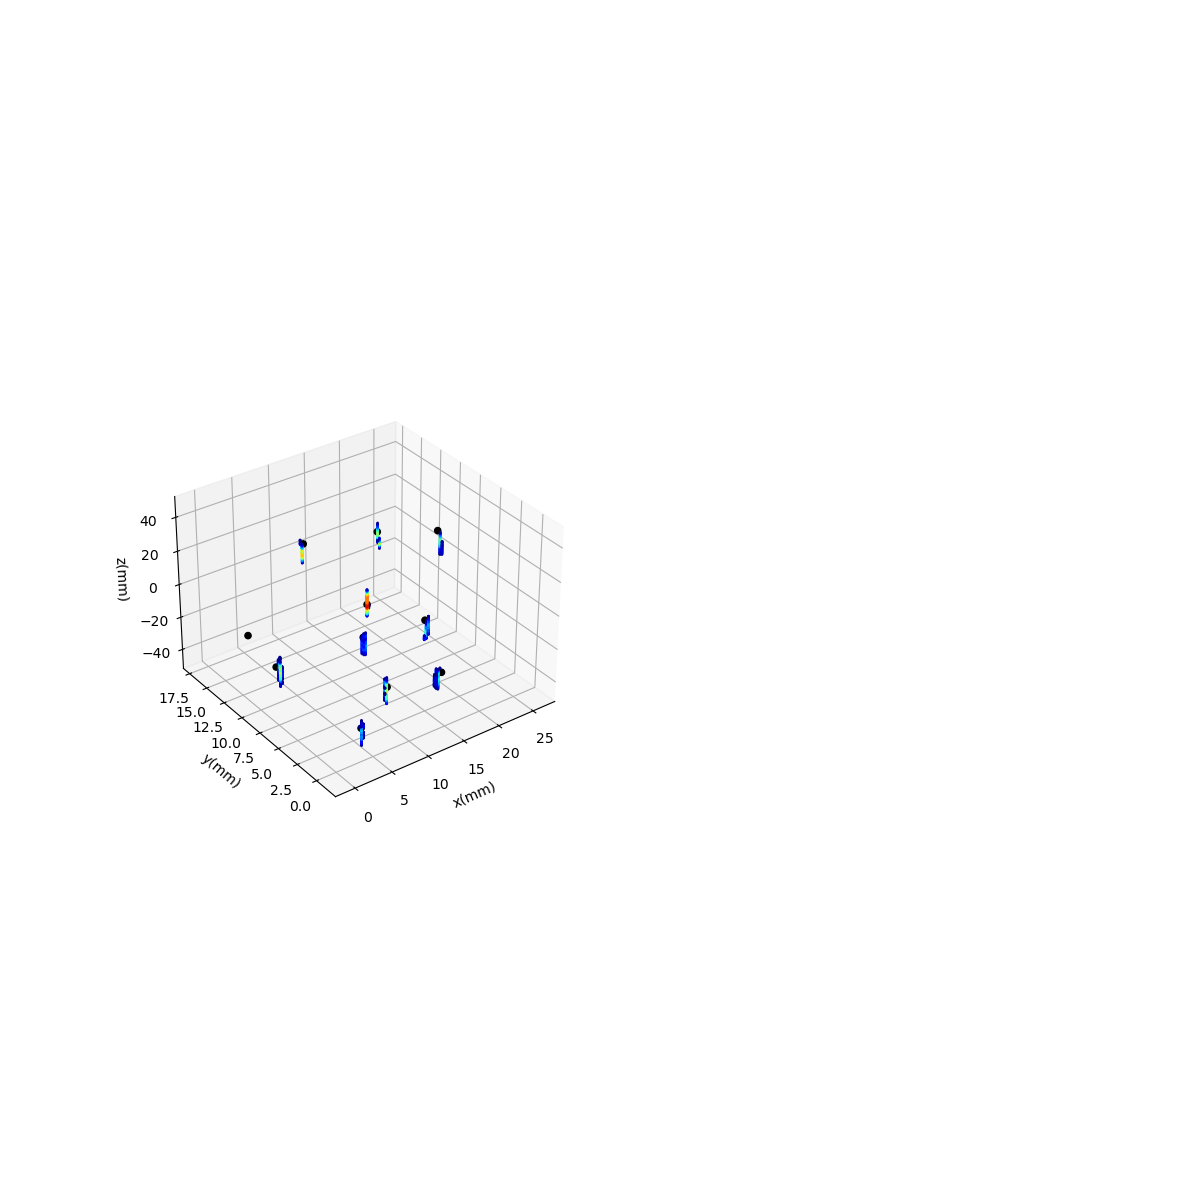

In [8]:
Point1_Path = '../ZoomLens_simulation/Points1.npy'
Point2_Path = '../ZoomLens_simulation/Points2.npy'
Point3_Path = '../ZoomLens_simulation/Points3.npy'
Point1_data = np.load(Point3_Path)

def recover_image_space(points):
    points = points * 1000
    z = -points[:,0]
    x = points[:,1]
    y = points[:,2]
    s1 = z - 41.209
    s2 = 1/(1/58 - 1/s1)
    new_z = s2- s2[0] - 2.5
    #ratio = np.divide(s2,s1)
    #new_x = np.multiply(ratio, -x) + 25.6/2
    #new_y = np.multiply(ratio, y) + 8
    new_x = 2.58 * -x + 25.6/2
    new_y = 2.58 * y + 8
    return [new_x, new_y, new_z]
[new_x, new_y, new_z] = recover_image_space(Point1_data)
fig = plt.figure(figsize = (12,12))
plt.clf()
ax = fig.add_subplot(121, projection='3d')
RayCounts = cloudpoints[2]
p1 = ax.scatter(RayCounts[:,0], RayCounts[:,1], RayCounts[:,2], c = RayCounts[:,3], cmap = 'jet', vmin = minRayCount, vmax = np.max(RayCounts[:,3]), s= 1)
p2 = ax.scatter(new_x, new_y, new_z, c='black',alpha = 1)
ax.set_xlim(Xmin, Xmax)
ax.set_ylim(Ymin, Ymax)
ax.set_zlim(Zmin, Zmax)
ax.set_xlabel('x(mm)')
ax.set_ylabel('y(mm)')
ax.set_zlabel('z(mm)')
ax.view_init(32, -126)


In [9]:
plt.close('all')

## 3.4 Visualize Ray Counts

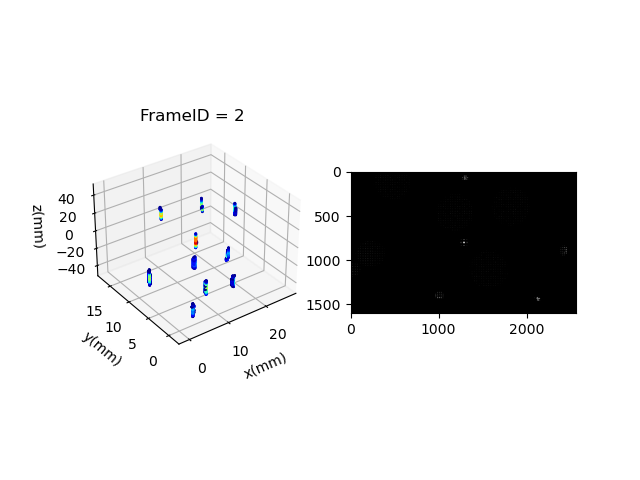

In [10]:

Show_RawCloudPoints = True # This line is for simulation only
if Show_RawCloudPoints:
    for i,RayCounts in enumerate(cloudpoints):
        fig = plt.figure(1)
        plt.clf()
        ax = fig.add_subplot(121, projection='3d')
        p = ax.scatter(RayCounts[:,0], RayCounts[:,1], RayCounts[:,2], c = RayCounts[:,3], cmap = 'jet', vmin = minRayCount, vmax = np.max(RayCounts[:,3]), s= 1)
        ax.set_title('FrameID = {}'.format(i))
        ax.set_xlim(Xmin, Xmax)
        ax.set_ylim(Ymin, Ymax)
        ax.set_zlim(Zmin, Zmax)
        ax.view_init(32, -126)
        #ax.view_init(-90,-90)
        ax.set_xlabel('x(mm)')
        ax.set_ylabel('y(mm)')
        ax.set_zlabel('z(mm)')
        img = mpimg.imread(ImageLists[i])
        ax2 = fig.add_subplot(122)
        ax2.imshow(img > threshold, cmap='gray')
        fig.savefig('./result/minThreshold/' + str(i).zfill(5) + '.jpg', dpi = 300)
if Video_RawCloudPoints:
    image_folder = './result/minThreshold'
    video_name = './result/minThreshold.avi'
    ImageNames = os.listdir(image_folder)
    ImageNames.sort() 
    images = [img for img in ImageNames if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MJPG'), 10, (width,height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()    

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 18.43it/s]


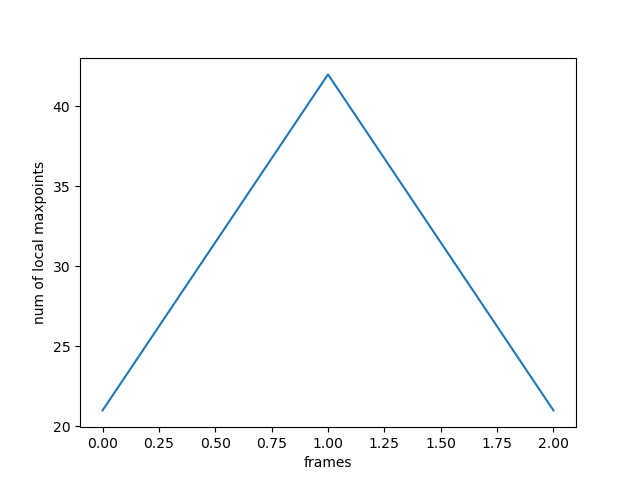

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import BallTree
searchRange = 4 * deltaX
AllFrameMaxPoints = []
AllFrameCenterPoints = []
AllFrameCenterPoints_Num = []
#start = time.time() 
for i in tqdm(range(len(cloudpoints))):
    RayCounts = cloudpoints[i]
    points = RayCounts[:,0:3]
    weight = np.array([1,1,0.2])
    weight = weight / np.linalg.norm(weight)
    tree = BallTree(points, metric = 'wminkowski', p = 2, w = weight)
    neighbors = tree.query_radius(points, r = searchRange)
    i_am_max = [RayCounts[:,3][k] == np.max(RayCounts[:,3][n]) for k,n in enumerate(neighbors)]
    maxIndex = np.nonzero(i_am_max)[0]
    maxPoints = RayCounts[maxIndex, :]
    AllFrameMaxPoints.append(maxPoints)
    AllFrameCenterPoints_Num.append(len(maxPoints))
#visualize number of points for each frame
AllFrameCenterPoints_Num = np.array(AllFrameCenterPoints_Num)
plt.figure()
plt.plot(AllFrameCenterPoints_Num)
plt.xlabel('frames')
plt.ylabel('num of local maxpoints')
plt.show()


In [ ]:
Show_BallCloudPoints = True #only for simulation
if Show_BallCloudPoints:
    for i,RayCounts in tqdm(enumerate(AllFrameMaxPoints)):
        fig = plt.figure(1)
        plt.clf()
        ax = fig.add_subplot(121, projection='3d')
        p = ax.scatter(RayCounts[:,0], RayCounts[:,1], RayCounts[:,2], c = RayCounts[:,3], cmap = 'jet', vmin = minRayCount, vmax = np.max(RayCounts[:,3]), s= 1)
        ax.set_title('FrameID = {}'.format(i))
        ax.set_xlim(Xmin, Xmax)
        ax.set_ylim(Ymin, Ymax)
        ax.set_zlim(Zmin, Zmax)
        ax.view_init(32, -126)
        #ax.view_init(-90,-90)
        ax.set_xlabel('x(mm)')
        ax.set_ylabel('y(mm)')
        ax.set_zlabel('z(mm)')
        img = mpimg.imread(ImageLists[i])
        ax2 = fig.add_subplot(122)
        ax2.imshow(img > threshold, cmap='gray')
        fig.savefig('./result/maxPoints/' + str(i).zfill(5) + '.jpg', dpi = 300)
if Video_BallCloudPoints:
    image_folder = './result/maxPoints'
    video_name = './result/maxPoints.avi'
    ImageNames = os.listdir(image_folder)
    ImageNames.sort() 
    images = [img for img in ImageNames if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MJPG'), 10, (width,height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()   
    
    

3it [00:00, 1223.07it/s]


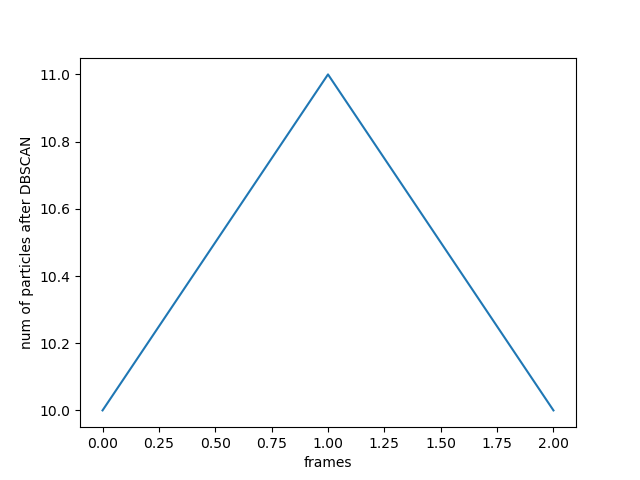

In [12]:
plt.close('all')
AllFrameDBSCANPoints = []
AllFrameDBSCANPoints_Num = []
from sklearn.cluster import DBSCAN
for i, RayCounts in tqdm(enumerate(AllFrameMaxPoints)):
    clustering = DBSCAN(eps = searchRange, min_samples = 1).fit(RayCounts[:,0:3])
    clusterLabel = clustering.labels_
    numCenters = np.max(clusterLabel) + 1
    points = np.zeros((numCenters,4)) # ! The particle center result after DBSCAN fit
    for label in range(numCenters):
        pointsIndex = np.where(clusterLabel == label)
        validPoints = RayCounts[pointsIndex]
        center = np.mean(validPoints, axis = 0)
        points[label,:] = center
    AllFrameDBSCANPoints.append(points)
    AllFrameDBSCANPoints_Num.append(numCenters)
AllFrameDBSCANPoints_Num= np.array(AllFrameDBSCANPoints_Num)
plt.figure()
plt.plot(AllFrameDBSCANPoints_Num)
plt.xlabel('frames')
plt.ylabel('num of particles after DBSCAN')
plt.show()

## * Simulation graph generator

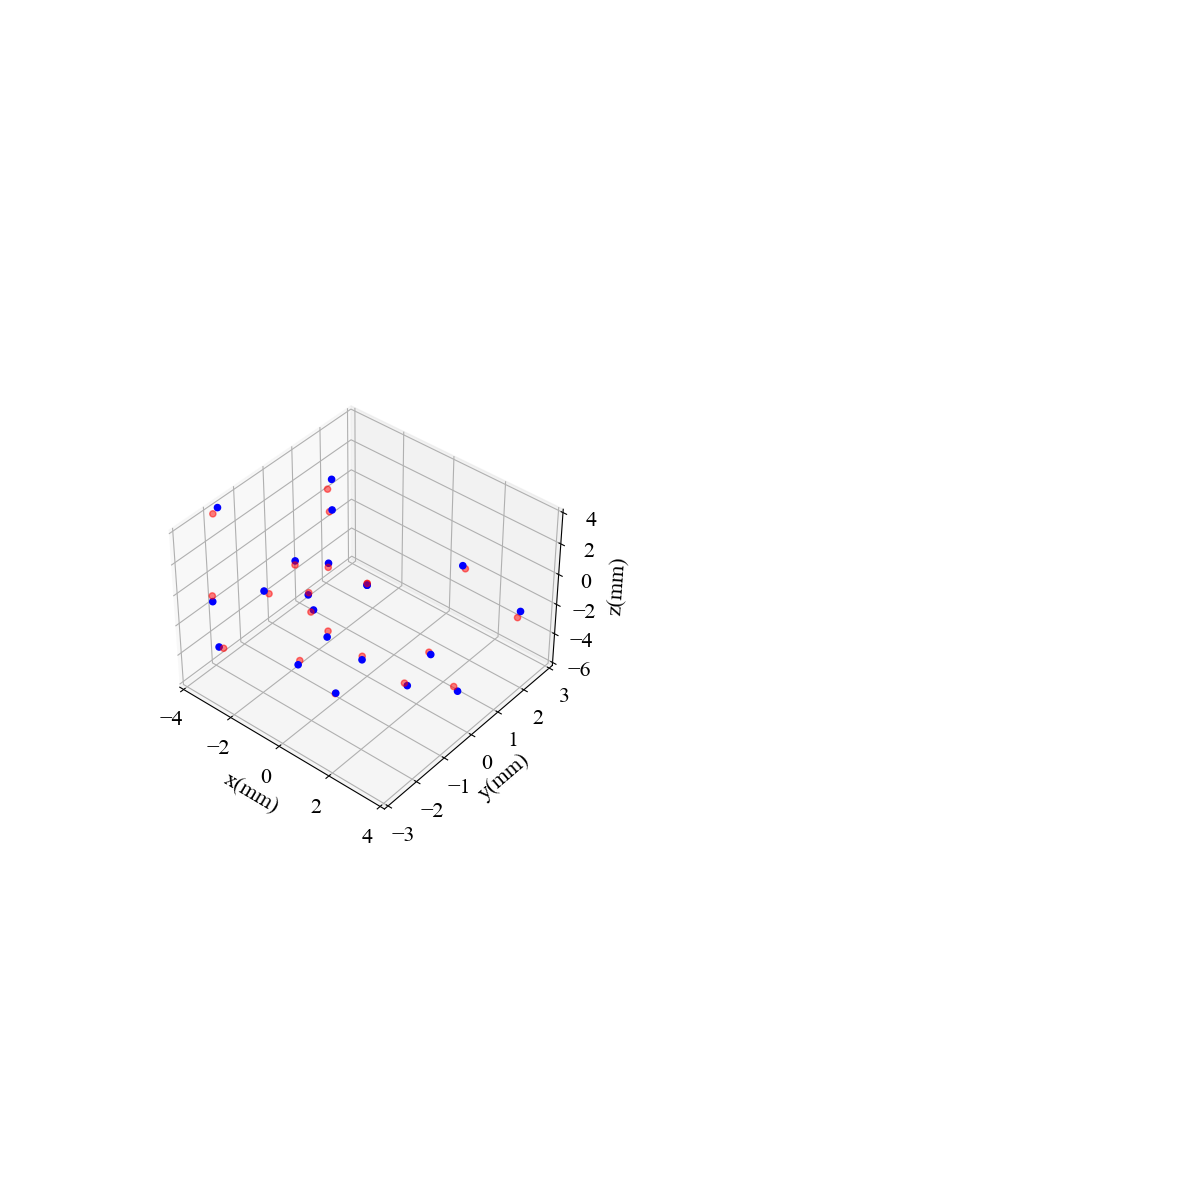

In [35]:
plt.close('All')
import matplotlib
matplotlib.rcParams["font.family"] = 'Times New Roman'
plt.rcParams.update({'font.size': 16})
Point1_Path = '../ZoomLens_simulation/Points1.npy'
Point2_Path = '../ZoomLens_simulation/Points2.npy'
Point3_Path = '../ZoomLens_simulation/Points3.npy'
Point1_data = np.load(Point1_Path)
Point2_data = np.load(Point2_Path)
Point3_data = np.load(Point3_Path)
def recover_image_space(points):
    points = points * 1000
    z = -points[:,0]
    x = points[:,1]
    y = points[:,2]
    s1 = z - 41.209
    s2 = 1/(1/57.14- 1/s1)
    #new_z = s2- s2[0] - 2.5
    
    new_z = -(z - z[0]) * 2.58 * 2.58 - 2.5
    #ratio = np.divide(s2,s1)
    #new_x = np.multiply(ratio, -x) + 25.6/2
    #new_y = np.multiply(ratio, y) + 8
    new_x = 2.56 * -x + 25.6/2
    new_y = 2.56 * y + 8
    return [new_x, new_y, new_z]

def recover_object_space(points, offset):
    new_points = np.copy(points)
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    ratio = 2.56
    new_x = -((x - 25.6/2)/ratio)
    new_y = (y - 8)/ratio
    new_z = (z - z[0])/2.58/2.58
    new_points[:,0] = new_x
    new_points[:,1] = new_y
    new_points[:,2] = new_z - offset
    return new_points
    

def eliminate_outlier(x,y,z):
    a = x > 0
    b = x < Xmax
    c = y > Ymin
    d = y < Ymax
    e = z > Zmin
    f = z < Zmax
    result = np.logical_and(a,b)
    result = np.logical_and(result,c)
    result = np.logical_and(result,d)
    result = np.logical_and(result,e)
    result = np.logical_and(result,f)
    return result
    
[new_x1, new_y1, new_z1] = recover_image_space(Point1_data)
[new_x2, new_y2, new_z2] = recover_image_space(Point2_data)
[new_x3, new_y3, new_z3] = recover_image_space(Point3_data)
index1 = eliminate_outlier(new_x1, new_y1, new_z1)
index2 = eliminate_outlier(new_x2, new_y2, new_z2)
index3 = eliminate_outlier(new_x3, new_y3, new_z3)
Point1_GT = Point1_data[index1,:] * 1000
Point2_GT = Point2_data[index2,:] * 1000
Point3_GT = Point3_data[index3,:] * 1000# ground truth calculated [z,x,y]
Point1_GT[:,0] = Point1_GT[:,0] - Point1_GT[0,0]
Point2_GT[:,0] = Point2_GT[:,0] - Point2_GT[0,0]
Point3_GT[:,0] = Point3_GT[:,0] - Point3_GT[0,0]
# finish calculate the groung truth

# recover the image reconstruction to target space 
points1 = AllFrameDBSCANPoints[0]
points2 = AllFrameDBSCANPoints[1]
points3 = AllFrameDBSCANPoints[2]

Point1_RC = recover_object_space(points1, 4.35670933)
Point2_RC = recover_object_space(points2, 5.95917713)
#Point3_RC = recover_object_space(points3)
fig = plt.figure(figsize = (12,12))
plt.clf()
ax = fig.add_subplot(121, projection='3d')
RayCounts = cloudpoints[2]
p1 = ax.scatter(Point1_GT[:,1], Point1_GT[:,2], Point1_GT[:,0], c = 'blue', alpha = 1)
p2 = ax.scatter(Point1_RC[:,0], Point1_RC[:,1], Point1_RC[:,2], c='red',alpha = 0.5)
p3 = ax.scatter(Point2_GT[:,1], Point2_GT[:,2], Point2_GT[:,0], c = 'blue', alpha = 1)
p4 = ax.scatter(Point2_RC[:,0], Point2_RC[:,1], Point2_RC[:,2], c='red',alpha = 0.5)
#p4 = ax.scatter(new_x2, new_y2, new_z2, c='red',alpha = 0.5)
#p5 = ax.scatter(points3[:,0], points3[:,1], points3[:,2], c = 'blue', alpha = 1)
#p6 = ax.scatter(new_x3, new_y3, new_z3, c='red',alpha = 0.5)
max_range = np.array([28/2.5, 18/2.5, 12]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0
# Comment or uncomment following both lines to test the fake bounding box:
#for xb, yb, zb in zip(Xb, Yb, Zb):
#   ax.plot([xb], [yb], [zb], 'w')
plt.grid()
#ax.set_aspect('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-3, 3)
ax.set_zlim(-6, 4)
ax.set_xlabel('x(mm)')
ax.set_ylabel('y(mm)')
ax.set_zlabel('z(mm)')
ax.view_init(40, -50)
fig.savefig('Simulation_Result.png', dpi=300)

In [55]:
import trackpy as tp
import pandas as pd

def tracking_2frame(points1, points2):
    column_names = ['x','y','z','frame']
    df = pd.DataFrame(columns = column_names)
    points_new = points1[:, [1,2,0]]
    points_new = np.append(points_new, np.ones([len(points_new), 1]) * 0, axis = 1)
    points2_new = np.append(points2[:,0:3], np.ones([len(points2), 1]) * 1, axis = 1)
    result1 = pd.DataFrame(points_new, columns = column_names)
    result2 = pd.DataFrame(points2_new, columns = column_names)
    return pd.concat([result1, result2])
data = tracking_2frame(Point1_GT,Point1_RC)
t = tp.link(data, search_range=3, memory = 0)
a = tp.motion.imsd(t, mpp = 1, fps = 1)
a = np.sqrt(a)
result = a.mean(axis = 1)
error = result.iloc[0]/0.04
print('The relative error for  ')

Frame 1: 10 trajectories present.


In [76]:
if Show_DBSCANCloudPoints:
    for i,RayCounts in tqdm(enumerate(AllFrameDBSCANPoints)):
        fig = plt.figure(1)
        plt.clf()
        ax = fig.add_subplot(121, projection='3d')
        p = ax.scatter(RayCounts[:,0], RayCounts[:,1], RayCounts[:,2], c = RayCounts[:,3], cmap = 'jet', vmin = minRayCount, vmax = np.max(RayCounts[:,3]), s= 1)
        ax.set_title('FrameID = {}'.format(i))
        ax.set_xlim(Xmin, Xmax)
        ax.set_ylim(Ymin, Ymax)
        ax.set_zlim(Zmin, Zmax)
        ax.view_init(32, -126)
        #ax.view_init(-90,-90)
        ax.set_xlabel('x(mm)')
        ax.set_ylabel('y(mm)')
        ax.set_zlabel('z(mm)')
        img = mpimg.imread(ImageLists[i])
        ax2 = fig.add_subplot(122)
        ax2.imshow(img > threshold, cmap='gray')
        fig.savefig('./result/DBSCAN/' + str(i).zfill(5) + '.jpg', dpi = 300)
if Video_DBSCANCloudPoints:
    image_folder = './result/DBSCAN'
    video_name = './result/DBSCAN.avi'
    ImageNames = os.listdir(image_folder)
    ImageNames.sort() 
    images = [img for img in ImageNames if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MJPG'), 10, (width,height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()   

In [ ]:
# negative depth mean far from focal plane, positive means closer to focal plane
import trackpy as tp
import pandas as pd
maginification = OpticInfo['magnification']
fLength = 25 # mm TODO: Add this into parmeter gui for future tuning.
column_names = ['x','y','z','mass','frame']
df = pd.DataFrame(columns = column_names)
for FrameID, points in enumerate(AllFrameDBSCANPoints):
    thisPoints = points.copy()
    for i in range(len(thisPoints)):
        thisPoints[i,0] /= maginification # convert to objective space
        thisPoints[i,1] /= maginification
        thisPoints[i,2] = (3.5 * fLength ** 2 + thisPoints[i,2] * fLength) / (2.5 * fLength + thisPoints[i,2]) -1.4 * fLength
    thisPoints = np.append(thisPoints, np.ones([len(thisPoints), 1]) * FrameID, axis = 1)
    thisPoints = pd.DataFrame(thisPoints, columns = column_names)
    df = pd.concat([df, thisPoints])
df.reset_index()

In [ ]:
#t = tp.link(df, search_range=(2,0.5,0.5), memory = 10)
t = tp.link(df, search_range=(2,0.5,0.5), memory = 50)
t1 = tp.filter_stubs(t, 50)
t1.index.name = ''
t_new = t1[0:0]
columns = t_new.columns
for i in np.unique(t1['particle'].to_numpy()):
    points = t1[t1['particle'] == i]
    minFrame = np.min(points['frame'])
    maxFrame = np.max(points['frame'])
    extra_frames = []
    for x in range(minFrame, maxFrame + 1):
        if not x in points['frame']:
            extra_frames.append([np.nan, np.nan, np.nan, 1, x, i])
    extra_frames = pd.DataFrame(extra_frames,columns = points.columns)
    points = points.append(extra_frames)
    points = points.sort_values(by = ['frame'])
    points = points.interpolate()
    points = points.reset_index(drop=True)
    x_new = savgol_filter(points['x'],31,5)
    points['x'] = x_new
    y_new = savgol_filter(points['y'],31,5)
    points['y'] = y_new
    z_new = savgol_filter(points['z'],31,5)
    points['z'] = z_new
    t_new = pd.concat([t_new, points])


In [ ]:
plt.figure()
tp.plot_traj3d(t_new) # TODO: Using ball tree angin to link trajetory in x,y,z,and time domain

In [ ]:
min_Frame = np.min(t_new['frame'])
max_Frame = np.max(t_new['frame'])

In [ ]:
Xmin_new = np.min(t_new['x'] - 1)
Xmax_new = np.max(t_new['x'] + 1)
Ymin_new = np.min(t_new['y'] - 1)
Ymax_new = np.max(t_new['y'] + 1)
Zmin_new = np.min(t_new['z'] - 1)
Zmax_new = np.max(t_new['z'] + 1)
for i in range(min_Frame, max_Frame + 1):
    fig = plt.figure(1)
    plt.clf()
    ax = fig.add_subplot(121, projection='3d')
    RayCounts = t_new[t_new['frame'] == i].to_numpy()
    p = ax.scatter(RayCounts[:,0], RayCounts[:,1], RayCounts[:,2],c = RayCounts[:,5], cmap = 'jet', vmin = np.min(t_new['particle']), vmax = np.max(t_new['particle']), s= 1)
    ax.set_title('FrameID = {}'.format(i))
    ax.set_xlim(Xmin_new, Xmax_new)
    ax.set_ylim(Ymin_new, Ymax_new)
    ax.set_zlim(Zmin_new, Zmax_new)
    ax.view_init(32, -126)
    #ax.view_init(-90,-90)
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    img = mpimg.imread(ImageLists[i])
    ax2 = fig.add_subplot(122)
    ax2.imshow(img > threshold, cmap='gray')
    fig.savefig('./result/Trackpy/' + str(i).zfill(5) + '.jpg', dpi = 300)

In [ ]:
image_folder = './result/Trackpy'
video_name = './result/Trackpy.avi'
ImageNames = os.listdir(image_folder)
ImageNames.sort() 
images = [img for img in ImageNames if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MJPG'), 10, (width,height))
for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))
cv2.destroyAllWindows()
video.release()   

# # %%
